# Length of stay in ED

Look at the length of stay in emergency department for all cases.

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns 
from scipy import stats

In [2]:
# adjust this to hide ID columns for posting to github
forrepo=False

hidecols = []
if forrepo:
    hidecols=['anon_id', 'pat_enc_csn_id_coded', 'inpatient_data_id_coded'] # these are hidden columns

Pulled adt table from sch_core_2021 for the 6_7 cohort using the following SQL:

```select * 
    from `som-nero-phi-jonc101.shc_core_2021.adt` as adt
    where adt.pat_enc_csn_id_coded 
    in (
        select pat_enc_csn_id_coded from 
            `som-nero-phi-jonc101.triageTD.6_7_cohort4`
    )```

In [4]:
# read in data files
datadir = "../../DataTD/shc2021"
outdir = "../../OutputTD/shc2021"

adt_file = datadir + "/cohort3_adt_2021.csv"
new_adt_file = datadir + "/cohort_6_7_adt.csv"
# results_file = resultsdir + "1_4_cohort_test_results.csv"
cohort_file = "../../OutputTD/shc2021/7_cohort4_3hr_labels_noOR.csv"


adt = pd.read_csv(adt_file)
# adt_2021 = pd.read_csv(new_adt_file)
# results = pd.read_csv(results_file)
cohort = pd.read_csv(cohort_file)

In [6]:
# just checking the cohorts
csns = cohort.pat_enc_csn_id_coded.unique()
adt_csns = adt.pat_enc_csn_id_coded.unique()

print("cohort csns: {}".format(len(csns)))
print("adt csns: {}".format(len(adt_csns)))

cohort csns: 52532
adt csns: 21284


In [131]:
# join the two adt tables together
full_adt = pd.concat([adt, adt_2021])
print(full_adt.pat_enc_csn_id_coded.nunique())

# keep only csns in our cohort
filtered_adt = full_adt[full_adt.pat_enc_csn_id_coded.isin(cohort.pat_enc_csn_id_coded)]
filtered_adt.head()

adt = filtered_adt # rename
adt.pat_enc_csn_id_coded.nunique()

60742


60464

In [132]:
# save this full adt table for later
savefile = "../../DataTD/cohort_6_7_all_adt.csv"
adt.to_csv(savefile, index=False)

In [133]:
# csns in our test cohort
results.pat_enc_csn_id_coded.nunique()

12418

# Format data

Convert datetime columns to the correct format.

In [134]:
adt.columns

Index(['anon_id', 'pat_enc_csn_id_coded', 'effective_time_jittered_utc',
       'seq_num_in_enc', 'pat_class', 'base_pat_class_c', 'pat_lvl_of_care_c',
       'pat_lv_of_care', 'event_type', 'pat_service', 'event_id_coded',
       'event_type_c', 'event_subtype_c', 'event_subtype', 'department_id',
       'pat_class_c', 'base_pat_class', 'pat_service_c', 'status_of_bed_c',
       'status_of_bed', 'xfer_event_id_coded', 'swap_event_id_coded',
       'reason_c', 'accommodation_c', 'accomodation', 'accom_reason_c',
       'adm_event_id_coded', 'dis_event_id_coded', 'xfer_in_event_id_coded',
       'next_out_event_id_coded', 'last_in_event_id_coded',
       'prev_event_id_coded', 'in_event_type_c', 'in_event_type',
       'out_event_type_c', 'out_event_type', 'from_base_class_c',
       'from_base_class', 'to_base_class_c', 'to_base_class',
       'seq_num_in_bed_min', 'labor_status_c', 'first_ip_in_ip_yn',
       'loa_reason_c', 'data_source', 'effective_time_jittered',
       'event_time

In [135]:
# add year of admit
adt['effective_year'] = pd.DatetimeIndex(adt['effective_time_jittered_utc']).year
adt.drop(hidecols, axis=1, errors='ignore').head()

<ipython-input-135-f2107e62f907>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adt['effective_year'] = pd.DatetimeIndex(adt['effective_time_jittered_utc']).year


,anon_id,pat_enc_csn_id_coded,effective_time_jittered_utc,seq_num_in_enc,pat_class,base_pat_class_c,pat_lvl_of_care_c,pat_lv_of_care,event_type,pat_service,...,death_24hr_max_label,death_24hr_recent_label,first_label,first_label_minutes_since_admit,acute_to_critical_label_recent,critical_to_acute_label_recent,acute_to_critical_label_max,critical_to_acute_label_max,previous_icu_visit,effective_year
0,JCcd7ba7,131277369526,2019-10-31 10:46:00 UTC,4,Inpatient,1.0,66.0,Neonatal ICU - VC Only,Patient Update,Emergency Medicine,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019
1,JCdc0a60,131281229519,2020-01-17 22:12:00 UTC,3,Inpatient,1.0,68.0,Newborn Nursery - VC Only,Patient Update,Emergency Medicine,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020
2,JC2a0efc1,131280575648,2019-12-06 07:22:00 UTC,6,Inpatient,1.0,68.0,Newborn Nursery - VC Only,Patient Update,Emergency,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019
3,JCdc5d49,131240161198,2017-10-08 06:59:00 UTC,2,Emergency Services,NaN,NaN,NaN,Census,Emergency,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017
4,JCe56297,131079845274,2015-04-02 06:59:00 UTC,2,Emergency Services,NaN,NaN,NaN,Census,Emergency,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015


In [136]:
# ** takes a long time to run **

# change the effective time to datetime since read in from csv
adt.effective_time_jittered_utc = pd.to_datetime(adt.effective_time_jittered_utc)

/home/eulalio/.local/lib/python3.8/site-packages/pandas/core/generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [137]:
# add the admit time column from the prediction results csv to the adt csv
admit_time = cohort[['pat_enc_csn_id_coded', 'admit_time']]

adt_admit = adt.merge(admit_time, how='left')
adt.head()

adt_admit.admit_time = pd.to_datetime(adt_admit.admit_time, utc=True)

adt_admit.columns

Index(['anon_id', 'pat_enc_csn_id_coded', 'effective_time_jittered_utc',
       'seq_num_in_enc', 'pat_class', 'base_pat_class_c', 'pat_lvl_of_care_c',
       'pat_lv_of_care', 'event_type', 'pat_service', 'event_id_coded',
       'event_type_c', 'event_subtype_c', 'event_subtype', 'department_id',
       'pat_class_c', 'base_pat_class', 'pat_service_c', 'status_of_bed_c',
       'status_of_bed', 'xfer_event_id_coded', 'swap_event_id_coded',
       'reason_c', 'accommodation_c', 'accomodation', 'accom_reason_c',
       'adm_event_id_coded', 'dis_event_id_coded', 'xfer_in_event_id_coded',
       'next_out_event_id_coded', 'last_in_event_id_coded',
       'prev_event_id_coded', 'in_event_type_c', 'in_event_type',
       'out_event_type_c', 'out_event_type', 'from_base_class_c',
       'from_base_class', 'to_base_class_c', 'to_base_class',
       'seq_num_in_bed_min', 'labor_status_c', 'first_ip_in_ip_yn',
       'loa_reason_c', 'data_source', 'effective_time_jittered',
       'event_time

In [138]:
# do we still have all of the CSNs? - YES
adt_admit.pat_enc_csn_id_coded.nunique()

60464

In [139]:
adt_admit.drop(hidecols, axis=1, errors='ignore').head()

,anon_id,pat_enc_csn_id_coded,effective_time_jittered_utc,seq_num_in_enc,pat_class,base_pat_class_c,pat_lvl_of_care_c,pat_lv_of_care,event_type,pat_service,...,death_24hr_max_label,death_24hr_recent_label,first_label,first_label_minutes_since_admit,acute_to_critical_label_recent,critical_to_acute_label_recent,acute_to_critical_label_max,critical_to_acute_label_max,previous_icu_visit,effective_year
0,JCcd7ba7,131277369526,2019-10-31 10:46:00+00:00,4,Inpatient,1.0,66.0,Neonatal ICU - VC Only,Patient Update,Emergency Medicine,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019
1,JCdc0a60,131281229519,2020-01-17 22:12:00+00:00,3,Inpatient,1.0,68.0,Newborn Nursery - VC Only,Patient Update,Emergency Medicine,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020
2,JC2a0efc1,131280575648,2019-12-06 07:22:00+00:00,6,Inpatient,1.0,68.0,Newborn Nursery - VC Only,Patient Update,Emergency,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019
3,JCdc5d49,131240161198,2017-10-08 06:59:00+00:00,2,Emergency Services,NaN,NaN,NaN,Census,Emergency,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017
4,JCe56297,131079845274,2015-04-02 06:59:00+00:00,2,Emergency Services,NaN,NaN,NaN,Census,Emergency,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015


In [140]:
# compute the time before admit for each of these events
adt_admit['time_before_admit'] = adt_admit.apply(lambda x: x.admit_time - x.effective_time_jittered_utc, axis=1)
adt_admit.drop(hidecols, axis=1, errors='ignore').head()

,anon_id,pat_enc_csn_id_coded,effective_time_jittered_utc,seq_num_in_enc,pat_class,base_pat_class_c,pat_lvl_of_care_c,pat_lv_of_care,event_type,pat_service,...,death_24hr_recent_label,first_label,first_label_minutes_since_admit,acute_to_critical_label_recent,critical_to_acute_label_recent,acute_to_critical_label_max,critical_to_acute_label_max,previous_icu_visit,effective_year,time_before_admit
0,JCcd7ba7,131277369526,2019-10-31 10:46:00+00:00,4,Inpatient,1.0,66.0,Neonatal ICU - VC Only,Patient Update,Emergency Medicine,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019,NaT
1,JCdc0a60,131281229519,2020-01-17 22:12:00+00:00,3,Inpatient,1.0,68.0,Newborn Nursery - VC Only,Patient Update,Emergency Medicine,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020,NaT
2,JC2a0efc1,131280575648,2019-12-06 07:22:00+00:00,6,Inpatient,1.0,68.0,Newborn Nursery - VC Only,Patient Update,Emergency,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019,NaT
3,JCdc5d49,131240161198,2017-10-08 06:59:00+00:00,2,Emergency Services,NaN,NaN,NaN,Census,Emergency,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017,NaT
4,JCe56297,131079845274,2015-04-02 06:59:00+00:00,2,Emergency Services,NaN,NaN,NaN,Census,Emergency,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015,NaT


We want to find the length of stay in the ED, so we'll add some columns to help figure out which ADT events mark the admission to Emergency services and transfer to Inpatient.

We're looking for:

- the first Inpatient event that follow Emergency Services (should be admit time)
- the first Emergency Services event

In [141]:
# mark the events with some labels that make things easier later

# sort by csn and time
adt_admit.sort_values(['pat_enc_csn_id_coded', 'seq_num_in_enc'], inplace=True)


# **assumes dataframe is sorted by time

# the first inpatient event following Emergency Services must meet these three criteria:
    # mark whether previous entry had pat class Emergency Services
adt_admit['prev_emerg'] = adt_admit.pat_class.shift() == 'Emergency Services'
    # mark whether current event has pat class Inpatient
adt_admit['curr_inpatient'] = adt_admit.pat_class == 'Inpatient'
    # mark whether current event is continued csn as previous
adt_admit['continued'] = adt_admit.pat_enc_csn_id_coded.eq(
    adt_admit.pat_enc_csn_id_coded.shift())

# find our cases by taking the AND of these columns
cols = ['prev_emerg', 'curr_inpatient', 'continued']
adt_admit['first_ip'] = adt_admit[cols].all(axis=1)

adt_admit.drop(hidecols, axis=1, errors='ignore').head()

,anon_id,pat_enc_csn_id_coded,effective_time_jittered_utc,seq_num_in_enc,pat_class,base_pat_class_c,pat_lvl_of_care_c,pat_lv_of_care,event_type,pat_service,...,critical_to_acute_label_recent,acute_to_critical_label_max,critical_to_acute_label_max,previous_icu_visit,effective_year,time_before_admit,prev_emerg,curr_inpatient,continued,first_ip
19178,JCe78a06,131062667066,2015-01-01 17:10:00+00:00,1,Emergency Services,3.0,NaN,NaN,Admission,Emergency,...,NaN,NaN,NaN,NaN,2015,NaT,False,False,False,False
19438,JCe78a06,131062667066,2015-01-02 00:32:00+00:00,2,Emergency Services,NaN,NaN,NaN,Transfer Out,Emergency,...,NaN,NaN,NaN,NaN,2015,NaT,True,False,True,False
19096,JCe78a06,131062667066,2015-01-02 00:32:00+00:00,3,Emergency Services,NaN,NaN,NaN,Transfer In,Emergency,...,NaN,NaN,NaN,NaN,2015,NaT,True,False,True,False
19434,JCe78a06,131062667066,2015-01-02 00:49:00+00:00,4,Emergency Services,NaN,NaN,NaN,Transfer Out,Emergency,...,NaN,NaN,NaN,NaN,2015,NaT,True,False,True,False
19100,JCe78a06,131062667066,2015-01-02 00:49:00+00:00,5,Emergency Services,NaN,NaN,NaN,Transfer In,Emergency,...,NaN,NaN,NaN,NaN,2015,NaT,True,False,True,False


Find the first emergency services pat_class for each csn.

In [142]:
# start by taking events that have a different pat class from the next event (below it)
change_pat = adt_admit[~adt_admit.pat_class.eq(adt_admit.pat_class.shift())]
change_pat.drop(hidecols, axis=1, errors='ignore').head()

,anon_id,pat_enc_csn_id_coded,effective_time_jittered_utc,seq_num_in_enc,pat_class,base_pat_class_c,pat_lvl_of_care_c,pat_lv_of_care,event_type,pat_service,...,critical_to_acute_label_recent,acute_to_critical_label_max,critical_to_acute_label_max,previous_icu_visit,effective_year,time_before_admit,prev_emerg,curr_inpatient,continued,first_ip
19178,JCe78a06,131062667066,2015-01-01 17:10:00+00:00,1,Emergency Services,3.0,NaN,NaN,Admission,Emergency,...,NaN,NaN,NaN,NaN,2015,NaT,False,False,False,False
217107,JCe78a06,131062667066,2015-01-02 01:01:00+00:00,7,Inpatient,1.0,6.0,Intermediate Care - With Cardiac Monitor,Transfer In,General Medicine (PAMF),...,NaN,NaN,NaN,NaN,2015,NaT,True,True,True,True
33,JCd1c19e,131062745090,2015-01-03 01:56:00+00:00,1,Emergency Services,3.0,NaN,NaN,Admission,Emergency,...,NaN,NaN,NaN,NaN,2015,NaT,False,False,False,False
294639,JCd1c19e,131062745090,2015-01-03 05:53:00+00:00,9,Inpatient,1.0,5.0,Acute Care (Assessment or intervention q4-8),Transfer In,Orthopaedic Surgery,...,NaN,NaN,NaN,NaN,2015,NaT,True,True,True,True
77116,JCd91eb2,131062747648,2015-01-01 01:10:00+00:00,1,Emergency Services,3.0,NaN,NaN,Admission,Emergency,...,NaN,NaN,NaN,NaN,2015,NaT,False,False,False,False


In [143]:
# lots of these still have many events - meaning they moved around a lot
change_pat.groupby('pat_enc_csn_id_coded').anon_id.count().value_counts()

2    58613
3     1224
4      568
5       43
6       12
1        2
8        2
Name: anon_id, dtype: int64

In [144]:
# keep the event with pat_class == Emergency Services, that occurs before the first inpatient event
# check to make sure that we're looking at the same CSN between both events
# don't take any where admit ocurred before ER event - happens when people move around a lot (ER -> Inpatient -> ER -> Inpatient)
keep_visits = change_pat[(change_pat.pat_class == 'Emergency Services') & 
                         (change_pat.shift(-1).first_ip) &
                         (change_pat.shift(-1).pat_enc_csn_id_coded == change_pat.pat_enc_csn_id_coded) & 
                         (change_pat.time_before_admit >= timedelta(days=0))] # remove this for now
keep_visits.drop(hidecols, axis=1, errors='ignore').head()

,anon_id,pat_enc_csn_id_coded,effective_time_jittered_utc,seq_num_in_enc,pat_class,base_pat_class_c,pat_lvl_of_care_c,pat_lv_of_care,event_type,pat_service,...,critical_to_acute_label_recent,acute_to_critical_label_max,critical_to_acute_label_max,previous_icu_visit,effective_year,time_before_admit,prev_emerg,curr_inpatient,continued,first_ip
1036996,JC641497,131284412456,2020-04-01 13:40:00+00:00,1,Emergency Services,3.0,NaN,NaN,Admission,Emergency,...,0.0,0.0,0.0,False,2020,0 days 03:54:00,False,False,False,False
1059275,JC2935494,131284535377,2020-04-03 03:18:00+00:00,1,Emergency Services,3.0,NaN,NaN,Admission,Emergency,...,0.0,0.0,0.0,False,2020,0 days 02:39:00,False,False,False,False
984607,JC2450325,131284556207,2020-04-07 08:02:00+00:00,1,Emergency Services,3.0,NaN,NaN,Admission,Emergency,...,0.0,0.0,0.0,False,2020,0 days 03:08:00,False,False,False,False
1123009,JC1505438,131285460671,2020-04-09 21:50:00+00:00,1,Emergency Services,3.0,NaN,NaN,Admission,Emergency,...,0.0,0.0,0.0,False,2020,0 days 02:32:00,False,False,False,False
876472,JC550704,131285470668,2020-04-08 00:34:00+00:00,1,Emergency Services,3.0,NaN,NaN,Admission,Emergency,...,0.0,0.0,0.0,False,2020,0 days 00:40:00,False,False,False,False


In [145]:
# look at the number of csn's that were dropped becuase admit time was before first ER event
print(change_pat.pat_enc_csn_id_coded.nunique())

print(keep_visits.pat_enc_csn_id_coded.nunique())

# we lose csns where admit occurs before the first ER - lost 2

60464
16484


In [146]:
# compute the time lapse between the ER visit and admission in hours
keep_visits['hours_before_admit'] = keep_visits.time_before_admit / np.timedelta64(1, 'h')
keep_visits.drop(hidecols, axis=1, errors='ignore').head()

<ipython-input-146-368242fbd5b0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  keep_visits['hours_before_admit'] = keep_visits.time_before_admit / np.timedelta64(1, 'h')


,anon_id,pat_enc_csn_id_coded,effective_time_jittered_utc,seq_num_in_enc,pat_class,base_pat_class_c,pat_lvl_of_care_c,pat_lv_of_care,event_type,pat_service,...,acute_to_critical_label_max,critical_to_acute_label_max,previous_icu_visit,effective_year,time_before_admit,prev_emerg,curr_inpatient,continued,first_ip,hours_before_admit
1036996,JC641497,131284412456,2020-04-01 13:40:00+00:00,1,Emergency Services,3.0,NaN,NaN,Admission,Emergency,...,0.0,0.0,False,2020,0 days 03:54:00,False,False,False,False,3.900000
1059275,JC2935494,131284535377,2020-04-03 03:18:00+00:00,1,Emergency Services,3.0,NaN,NaN,Admission,Emergency,...,0.0,0.0,False,2020,0 days 02:39:00,False,False,False,False,2.650000
984607,JC2450325,131284556207,2020-04-07 08:02:00+00:00,1,Emergency Services,3.0,NaN,NaN,Admission,Emergency,...,0.0,0.0,False,2020,0 days 03:08:00,False,False,False,False,3.133333
1123009,JC1505438,131285460671,2020-04-09 21:50:00+00:00,1,Emergency Services,3.0,NaN,NaN,Admission,Emergency,...,0.0,0.0,False,2020,0 days 02:32:00,False,False,False,False,2.533333
876472,JC550704,131285470668,2020-04-08 00:34:00+00:00,1,Emergency Services,3.0,NaN,NaN,Admission,Emergency,...,0.0,0.0,False,2020,0 days 00:40:00,False,False,False,False,0.666667


# Now look at time in ED

In [147]:
# print(keep_visits.columns)

print(keep_visits.hours_before_admit.describe())

keep_visits['hours_before_admit_quantile'] = pd.qcut(keep_visits.hours_before_admit, 10)

count    16484.000000
mean         4.226969
std          4.913630
min          0.016667
25%          2.333333
50%          3.450000
75%          4.950000
max        145.066667
Name: hours_before_admit, dtype: float64


<ipython-input-147-5f0033c6c3f0>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  keep_visits['hours_before_admit_quantile'] = pd.qcut(keep_visits.hours_before_admit, 10)


In [148]:
print(keep_visits.columns)

# grab the year from the admit time
keep_visits['test_set'] = keep_visits.pat_enc_csn_id_coded.isin(results.pat_enc_csn_id_coded)

keep_visits.drop(hidecols, axis=1, errors='ignore').head()

Index(['anon_id', 'pat_enc_csn_id_coded', 'effective_time_jittered_utc',
       'seq_num_in_enc', 'pat_class', 'base_pat_class_c', 'pat_lvl_of_care_c',
       'pat_lv_of_care', 'event_type', 'pat_service', 'event_id_coded',
       'event_type_c', 'event_subtype_c', 'event_subtype', 'department_id',
       'pat_class_c', 'base_pat_class', 'pat_service_c', 'status_of_bed_c',
       'status_of_bed', 'xfer_event_id_coded', 'swap_event_id_coded',
       'reason_c', 'accommodation_c', 'accomodation', 'accom_reason_c',
       'adm_event_id_coded', 'dis_event_id_coded', 'xfer_in_event_id_coded',
       'next_out_event_id_coded', 'last_in_event_id_coded',
       'prev_event_id_coded', 'in_event_type_c', 'in_event_type',
       'out_event_type_c', 'out_event_type', 'from_base_class_c',
       'from_base_class', 'to_base_class_c', 'to_base_class',
       'seq_num_in_bed_min', 'labor_status_c', 'first_ip_in_ip_yn',
       'loa_reason_c', 'data_source', 'effective_time_jittered',
       'event_time

<ipython-input-148-15ec4b1adf5f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  keep_visits['test_set'] = keep_visits.pat_enc_csn_id_coded.isin(results.pat_enc_csn_id_coded)


,anon_id,pat_enc_csn_id_coded,effective_time_jittered_utc,seq_num_in_enc,pat_class,base_pat_class_c,pat_lvl_of_care_c,pat_lv_of_care,event_type,pat_service,...,previous_icu_visit,effective_year,time_before_admit,prev_emerg,curr_inpatient,continued,first_ip,hours_before_admit,hours_before_admit_quantile,test_set
1036996,JC641497,131284412456,2020-04-01 13:40:00+00:00,1,Emergency Services,3.0,NaN,NaN,Admission,Emergency,...,False,2020,0 days 03:54:00,False,False,False,False,3.900000,"(3.45, 3.95]",False
1059275,JC2935494,131284535377,2020-04-03 03:18:00+00:00,1,Emergency Services,3.0,NaN,NaN,Admission,Emergency,...,False,2020,0 days 02:39:00,False,False,False,False,2.650000,"(2.55, 2.983]",False
984607,JC2450325,131284556207,2020-04-07 08:02:00+00:00,1,Emergency Services,3.0,NaN,NaN,Admission,Emergency,...,False,2020,0 days 03:08:00,False,False,False,False,3.133333,"(2.983, 3.45]",False
1123009,JC1505438,131285460671,2020-04-09 21:50:00+00:00,1,Emergency Services,3.0,NaN,NaN,Admission,Emergency,...,False,2020,0 days 02:32:00,False,False,False,False,2.533333,"(2.1, 2.55]",False
876472,JC550704,131285470668,2020-04-08 00:34:00+00:00,1,Emergency Services,3.0,NaN,NaN,Admission,Emergency,...,False,2020,0 days 00:40:00,False,False,False,False,0.666667,"(0.0157, 1.55]",False


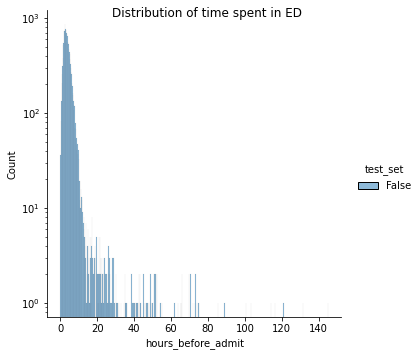

In [149]:
# visualize distribution
p = sns.displot(keep_visits,
               x='hours_before_admit',
                hue = 'test_set'
               )
p.fig.suptitle("Distribution of time spent in ED")
p.fig.get_axes()[0].set_yscale('log')
plt.show()

In [150]:
# look at time spent in ED for train and test sets
keep_visits.groupby('test_set').hours_before_admit.describe()

,count,mean,std,min,25%,50%,75%,max
test_set,,,,,,,,
False,16484.0,4.226969,4.91363,0.016667,2.333333,3.45,4.95,145.066667


In [151]:
# look at time spent in ED for entire cohort
keep_visits.hours_before_admit.describe()

count    16484.000000
mean         4.226969
std          4.913630
min          0.016667
25%          2.333333
50%          3.450000
75%          4.950000
max        145.066667
Name: hours_before_admit, dtype: float64

In [152]:
keep_visits.drop(hidecols, axis=1, errors='ignore').head()

,anon_id,pat_enc_csn_id_coded,effective_time_jittered_utc,seq_num_in_enc,pat_class,base_pat_class_c,pat_lvl_of_care_c,pat_lv_of_care,event_type,pat_service,...,previous_icu_visit,effective_year,time_before_admit,prev_emerg,curr_inpatient,continued,first_ip,hours_before_admit,hours_before_admit_quantile,test_set
1036996,JC641497,131284412456,2020-04-01 13:40:00+00:00,1,Emergency Services,3.0,NaN,NaN,Admission,Emergency,...,False,2020,0 days 03:54:00,False,False,False,False,3.900000,"(3.45, 3.95]",False
1059275,JC2935494,131284535377,2020-04-03 03:18:00+00:00,1,Emergency Services,3.0,NaN,NaN,Admission,Emergency,...,False,2020,0 days 02:39:00,False,False,False,False,2.650000,"(2.55, 2.983]",False
984607,JC2450325,131284556207,2020-04-07 08:02:00+00:00,1,Emergency Services,3.0,NaN,NaN,Admission,Emergency,...,False,2020,0 days 03:08:00,False,False,False,False,3.133333,"(2.983, 3.45]",False
1123009,JC1505438,131285460671,2020-04-09 21:50:00+00:00,1,Emergency Services,3.0,NaN,NaN,Admission,Emergency,...,False,2020,0 days 02:32:00,False,False,False,False,2.533333,"(2.1, 2.55]",False
876472,JC550704,131285470668,2020-04-08 00:34:00+00:00,1,Emergency Services,3.0,NaN,NaN,Admission,Emergency,...,False,2020,0 days 00:40:00,False,False,False,False,0.666667,"(0.0157, 1.55]",False


In [153]:
# save the hours before 
final_visits = keep_visits[['pat_enc_csn_id_coded', 'hours_before_admit']]

final_visits.rename({'hours_before_admit': 'hours_in_ed'}, axis=1, inplace=True)

print(final_visits.shape)
print(final_visits.pat_enc_csn_id_coded.nunique())

final_visits.drop(hidecols, axis=1, errors='ignore').head()

(16484, 2)
16484


/home/eulalio/.local/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,pat_enc_csn_id_coded,hours_in_ed
1036996,131284412456,3.900000
1059275,131284535377,2.650000
984607,131284556207,3.133333
1123009,131285460671,2.533333
876472,131285470668,0.666667


In [154]:
savedir = "../../OutputTD/5_results_analysis/"
savefile = savedir + "5_1_length_of_stay_in_ED.csv"

final_visits.to_csv(savefile, index=False)